<a href="https://colab.research.google.com/github/Ndthain25092002/Hate-speech-detection/blob/main/HS_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [ ]:
!pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.8 MB/s eta 0:00:00


In [ ]:
!pip install torch

In [ ]:
!pip install keras


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Embedding, Dropout, Bidirectional, LSTM, GRU, Input, GlobalMaxPooling1D, LayerNormalization
import string
import warnings
from tensorflow import keras
from keras import layers
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from pyvi import ViUtils
from keras.optimizers import Adam, SGD
from keras.layers import Conv1D
from pyparsing.helpers import Combine
from keras.api._v2.keras import initializers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense

In [ ]:
df = pd.read_csv('train.csv')
df.head()

,free_text,label_id
0,Đúng là bọn mắt híp lò xo thụt :))) bên việt n...,hate
1,CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯ...,hate
2,Lúp lúp như chó .,offensive
3,"Thế mà mình nói mấy thằng bắc kì, bọn đó lại b...",hate
4,Cắt cho trẻ trâu bớt thui mà 😂😂😂,normal


In [ ]:
df.shape

(10471, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10471 entries, 0 to 10470
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   free_text  10471 non-null  object
 1   label_id   10471 non-null  object
dtypes: object(2)
memory usage: 163.7+ KB


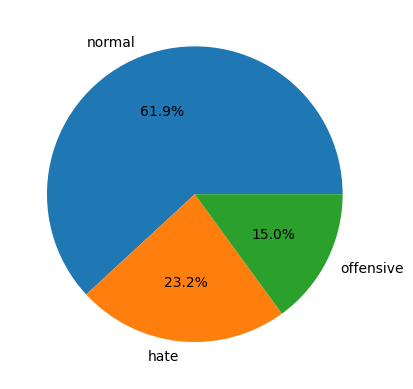

In [ ]:
plt.pie(df['label_id'].value_counts().values,
        labels = df['label_id'].value_counts().index,
        autopct='%1.1f%%')
plt.show()


In [ ]:
# loại bỏ dấu, đưa về dạng viết thường. Xử lí dữ liệu song song trên cả 2 bộ đã remove và ko
input_label = df['label_id'].values
input_data = df['free_text'].values
label_dict = {'normal':0, 'offensive':1, 'hate':2}
input_pre = []
label_with_accent = []
for idx, dt in enumerate(input_data):
    input_text_pre = list (tf.keras.preprocessing.text.text_to_word_sequence(dt))
    input_text_pre = " ".join(input_text_pre)
    input_text_pre_no_accent = str(ViUtils.remove_accents(input_text_pre).decode("utf-8"))
    input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
    input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)
    input_pre.append(input_text_pre_accent)
    input_pre.append(input_text_pre_no_accent)
    label_with_accent.append(input_label[idx])
    label_with_accent.append(input_label[idx])

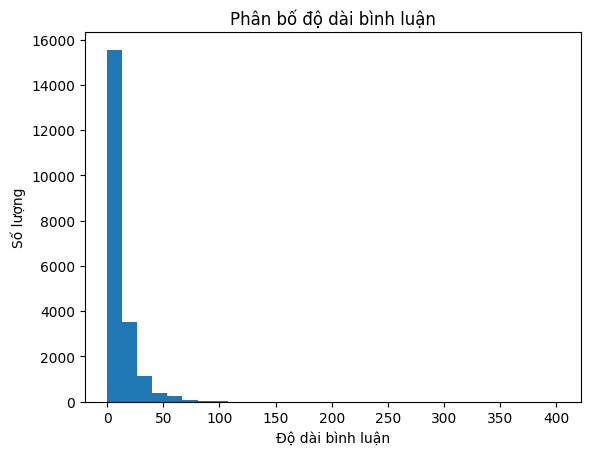

In [ ]:
# Tính độ dài của các lời lẽ
lengths = [len(sentence.split()) for sentence in input_pre]

# Vẽ biểu đồ histogram
plt.hist(lengths, bins=30)
plt.xlabel('Độ dài bình luận')
plt.ylabel('Số lượng')
plt.title('Phân bố độ dài bình luận')
plt.show()

In [ ]:
label_idx = [label_dict[i] for i in label_with_accent]
label_tf= tf.keras.utils.to_categorical(label_idx, num_classes=3, dtype='float32')
# Tạo tokenizer và chuyển đổi dữ liệu thành chuỗi số nguyên
tokenizer_data = Tokenizer(oov_token='<OOV>', filters = '', split=' ')
tokenizer_data.fit_on_texts(input_pre)
tokenizer_data_text = tokenizer_data.texts_to_sequences(input_pre)
vec_data = pad_sequences(tokenizer_data_text, padding='post', maxlen= 200)

pickle.dump(tokenizer_data, open("tokenizer_data.pkl", "wb"))

print("input data: ", vec_data.shape)
data_vocab_size = len(tokenizer_data.word_index)+1
# Chia dữ liệu thành tập train, val và test
print("data_vocab_size: ",data_vocab_size )
X_train, X_val, Y_train, Y_val = train_test_split(vec_data, label_tf , test_size=0.2, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train  , test_size=0.1, random_state=42)
print("train sample: " , len(X_train))
print("valdition sample: ",len(X_val))
print("test sample: ", len(X_test))

input data:  (20942, 200)
data_vocab_size:  13644
train sample:  15077
valdition sample:  4189
test sample:  1676


In [ ]:
def generate_model():
    dropout_threshold = 0.2
    input_dim = data_vocab_size
    output_dim = 32
    input_length = 200
    initializer = tf.keras.initializers.GlorotNormal()  #khởi tạo trọng số
#CNN
    input_layer = Input(shape=(input_length))
    feature = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, embeddings_initializer="GlorotNormal")(input_layer)

    cnn_feature = Conv1D(filters = 32, kernel_size = 2, padding = 'same', activation='relu')(feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    cnn_feature = Conv1D(filters = 32, kernel_size = 2, padding = 'same', activation='relu')(cnn_feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
# Bi_LSTM + Bi_GRU
    bi_lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer ), merge_mode='concat')(feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)

    bi_lstm_feature = Bidirectional(GRU(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer ), merge_mode='concat')(bi_lstm_feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)
# kết hợp 2 đặc trưng
    combine_feature = tf.keras.layers.Concatenate()([cnn_feature, bi_lstm_feature])
    combine_feature = GlobalMaxPooling1D()(combine_feature)
    combine_feature = LayerNormalization()(combine_feature)

    classifier = Dense(90, activation = 'relu')(combine_feature)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(70, activation = 'relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(50, activation = 'relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(30, activation = 'relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(3, activation = 'softmax')(classifier)

    model = tf.keras.Model(inputs=input_layer, outputs=classifier)

    return model
model = generate_model()
adam =Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 200, 32)              436608    ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 200, 32)              2080      ['embedding[0][0]']           
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 100, 32)              0         ['conv1d[0][0]']              
 D)                                                                                           

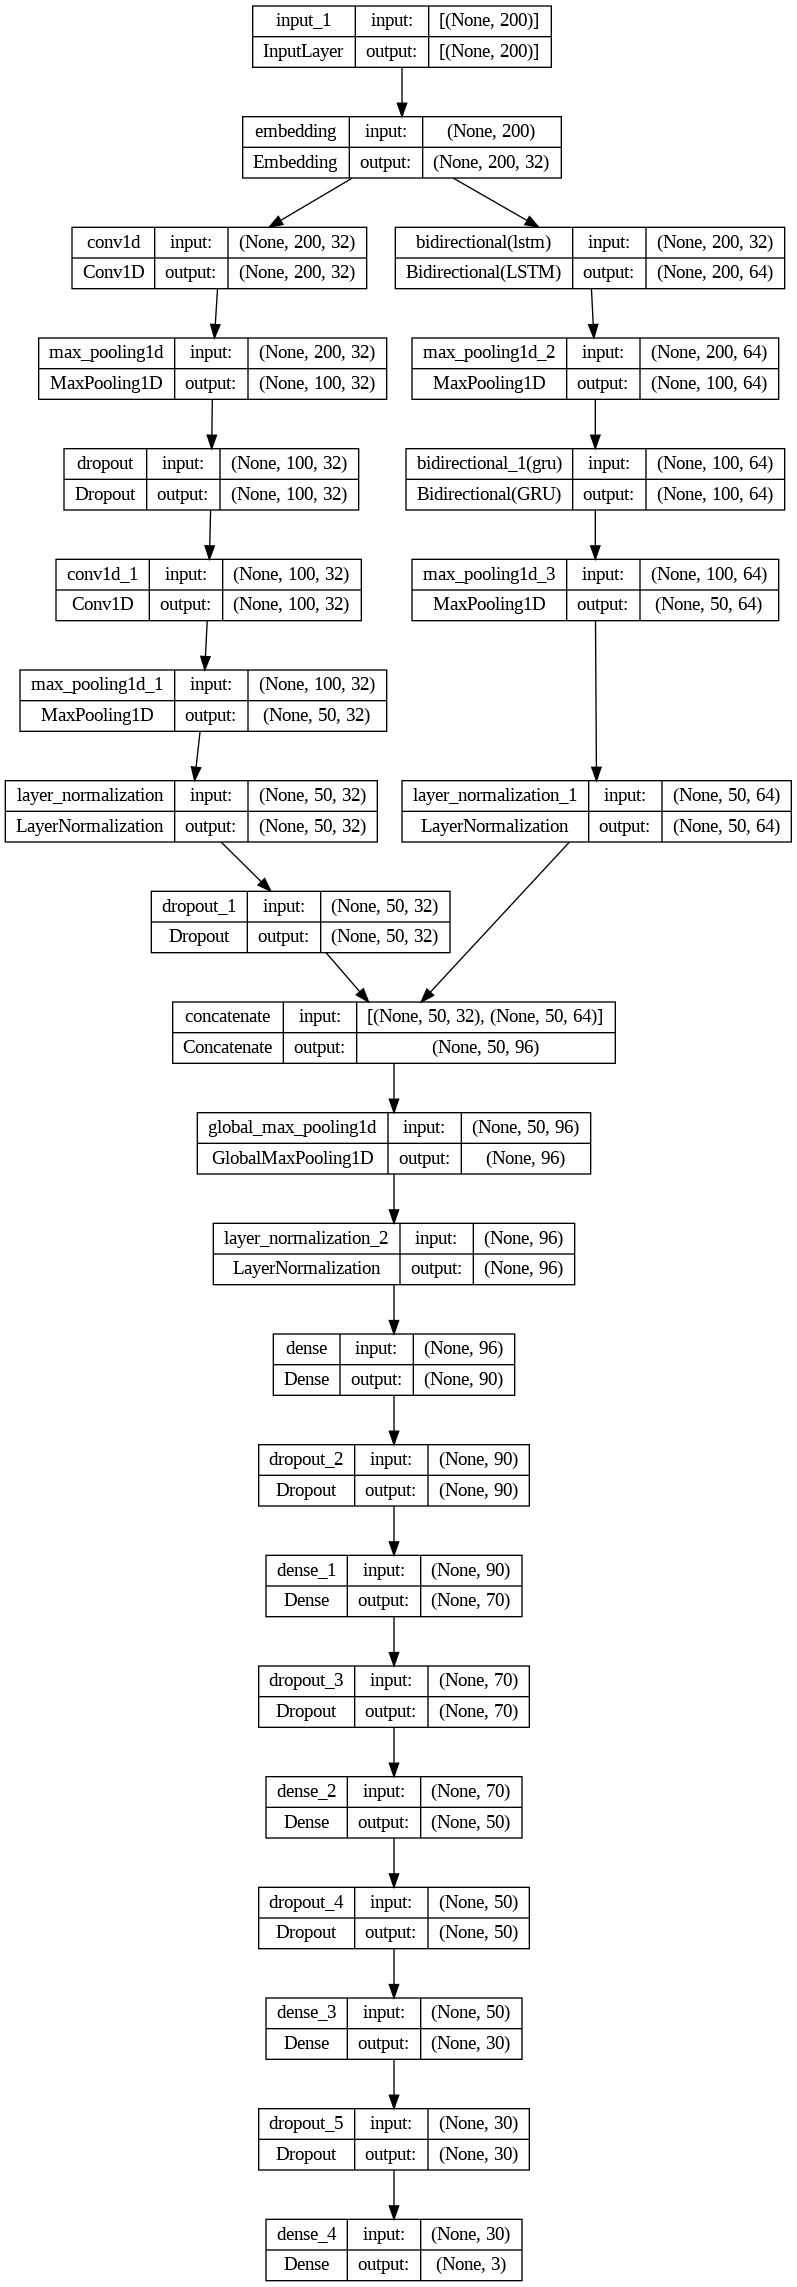

In [ ]:
dot_img_file = 'model_visualize.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_cnn_bilstm.h5', monitor='val_loss')
history = model.fit(x=X_train, y=Y_train, validation_data = (X_val, Y_val), epochs=10, batch_size =128, callbacks=[callback_model])

Epoch 1/10
118/118 [==============================] - 43s 186ms/step - loss: 0.9075 - accuracy: 0.6247 - val_loss: 0.8229 - val_accuracy: 0.6429
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


118/118 [==============================] - 11s 89ms/step - loss: 0.6947 - accuracy: 0.7263 - val_loss: 0.6574 - val_accuracy: 0.7262
Epoch 3/10
118/118 [==============================] - 8s 67ms/step - loss: 0.5477 - accuracy: 0.7736 - val_loss: 0.6311 - val_accuracy: 0.7458
Epoch 4/10
118/118 [==============================] - 7s 64ms/step - loss: 0.4524 - accuracy: 0.8131 - val_loss: 0.6571 - val_accuracy: 0.7379
Epoch 5/10
118/118 [==============================] - 6s 50ms/step - loss: 0.3790 - accuracy: 0.8543 - val_loss: 0.6672 - val_accuracy: 0.7742
Epoch 6/10
118/118 [==============================] - 7s 58ms/step - loss: 0.3189 - accuracy: 0.8837 - val_loss: 0.6841 - val_accuracy: 0.7598
Epoch 7/10
118/118 [==============================] - 5s 42ms/step - loss: 0.2659 - accuracy: 0.9057 - val_loss: 0.7620 - val_accuracy: 0.7634
Epoch 8/10
118/118 [==============================] - 6s 54ms/step - loss: 0.2236 - accuracy: 0.9213 - val_loss: 0.7203 - val_accuracy: 0.7732
Epoch 9/1

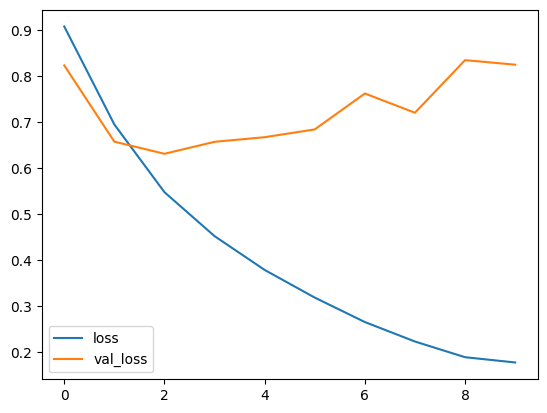

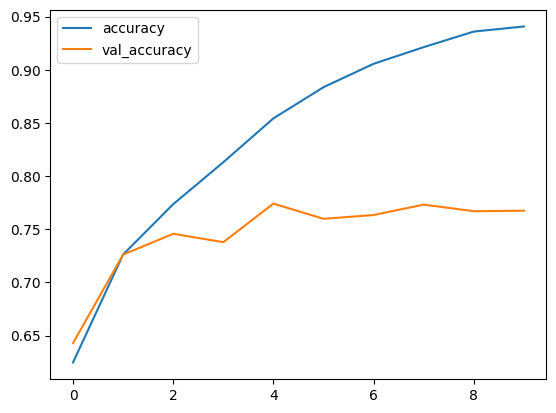

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

In [ ]:
model.load_weights("model_cnn_bilstm.h5")
model.evaluate(X_test, Y_test)

53/53 [==============================] - 1s 15ms/step - loss: 0.8067 - accuracy: 0.7625


[0.8066577911376953, 0.7625298500061035]